In [1]:
from functions import *

In [2]:
@jit
def likelihood(dmap_flat, ref_dmap_flat, measurement_error, num_probes):
    """ 
    """
    return jnp.prod(jnp.array(likelihood_(dmap_flat, ref_dmap_flat, measurement_error, num_probes)))

In [3]:
@jit
def likelihood_(dmap_flat, ref_dmap_flat, measurement_error, num_probes):
    """
    """
    # Calculate the difference between distance map and reference 
    # distance map
    subtraction_map_sq = (dmap_flat - ref_dmap_flat)**2
    sum_subtraction_map_sq = jnp.sum(subtraction_map_sq)
    
    # Calculate the normalization factor
    normalization_factor = 1/((jnp.sqrt(2*np.pi)*measurement_error)**((num_probes)**2))
    
    # Calculate the gaussian term 
    gaussian_term = jnp.exp(-jnp.sum(sum_subtraction_map_sq)/(2*measurement_error**2))
    
    # print('Scaling factor = {}'.format(normalization_factor))
    # print('Gaussian term = {}'.format(gaussian_term))
    
    return normalization_factor, gaussian_term

In [4]:
@jit
def loglikelihood(dmap_flat, ref_dmap_flat, measurement_error, num_probes):
    """
    """
    return jnp.sum(jnp.array(loglikelihood_(dmap_flat, ref_dmap_flat, measurement_error, num_probes)))

In [5]:
@jit
def loglikelihood_(dmap_flat, ref_dmap_flat, measurement_error, num_probes):
    """ 
    """
    # Calculate the difference between distance map and reference 
    # distance map
    subtraction_map_sq = jnp.square(dmap_flat - ref_dmap_flat)
    sum_subtraction_map_sq = jnp.sum(subtraction_map_sq)
    
    # Calculate the normalization factor
    normalization_factor = -jnp.square(num_probes) * jnp.log(jnp.sqrt(2*np.pi*jnp.square(measurement_error)))
    
    # Calculate the gaussian term 
    gaussian_term = -jnp.sum(sum_subtraction_map_sq)/(2*jnp.square(measurement_error))
    
    # print('Scaling factor = {}'.format(normalization_factor))
    # print('Gaussian term = {}'.format(gaussian_term))
    
    return normalization_factor, gaussian_term

In [6]:
def prior(dmap_flat, num_probes):
    """
    """
    return jnp.prod(jnp.array(prior_(dmap_flat, num_probes)))

In [7]:
def prior_(dmap_flat, num_probes):
    """
    """
    # Get 2D map back to simplify the expression 
    dmap = jnp.reshape(dmap_flat, [num_probes, num_probes])
    
    # Calculate the squared end-to-end distance 
    R_sq = dmap[0][-1] ** 2
    
    # Calculate the average bond length
    b = jnp.mean(jnp.diag(dmap, 1))
    
    N = num_probes
    
    # Calculate the probability
    scaling_factor = (3/(2*np.pi*N*b**2)) ** 1.5
    gaussian_term = jnp.exp(-3*R_sq/(2*N*b**2))
    
    # print('Scaling factor = {}'.format(scaling_factor))
    # print('Gaussian term = {}'.format(gaussian_term))
    
    return scaling_factor, gaussian_term 

In [8]:
def logprior(dmap_flat, num_probes):
    """
    """
    return jnp.sum(jnp.array(logprior_(dmap_flat, num_probes)))

In [9]:
def logprior_(dmap_flat, num_probes):
    """
    """
    # Get 2D map back to simplify the expression 
    dmap = jnp.reshape(dmap_flat, [num_probes, num_probes])
    
    # Calculate the squared end-to-end distance 
    R_sq = dmap[0][-1] ** 2
    
    # Calculate the average bond length
    b = jnp.mean(jnp.diag(dmap, 1))
    
    N = num_probes
    
    # Calculate the probability
    scaling_factor = 1.5 * jnp.log(3/(2*np.pi*N*b**2))
    gaussian_term = -3*R_sq/(2*N*b**2)
    
    # print('Scaling factor = {}'.format(scaling_factor))
    # print('Gaussian term = {}'.format(gaussian_term))
    
    return scaling_factor, gaussian_term 

In [10]:
num_monomers = 20
mean_bond_length = 1
std_bond_length = 20

template_chain = generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)

In [11]:
num_observations = 10
gaussian_noise_std = 10

observations = generate_observations(template_chain, num_observations, gaussian_noise_std)

In [12]:
template_chain_flatten = generate_flatten_distance_map(template_chain)

In [13]:
observations_flatten = [generate_flatten_distance_map(c) for c in observations]

In [14]:
measurement_error = 10
num_probes = num_monomers
loglikelihood_(jnp.array(template_chain_flatten), jnp.array(template_chain_flatten), measurement_error, num_probes)

2024-05-15 16:02:33.547985: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(Array(-1288.6095, dtype=float32, weak_type=True), Array(-0., dtype=float32))

In [15]:
measurement_error = 10
num_probes = num_monomers

ll_template = loglikelihood(template_chain_flatten, template_chain_flatten, measurement_error, num_probes)

In [16]:
measurement_error = 10
lls = [loglikelihood(template_chain_flatten, x, measurement_error, num_probes) for x in observations_flatten]

In [17]:
likelihood(template_chain_flatten, observations_flatten[0], measurement_error, num_probes)

Array(0., dtype=float32)

In [18]:
prior(template_chain_flatten, num_probes)

Array(9.203736e-08, dtype=float32)

In [19]:
jscipy.special.logsumexp(jnp.array(lls))

Array(-1611.9225, dtype=float32)

In [18]:
def generate_posterior(templates, observations, template_weights, weight_renormalization=1000):
    """
    """
    templates_flatten = [generate_flatten_distance_map(t) for t in templates]
    observations_flatten = [generate_flatten_distance_map(o) for o in observations]
    
    weight_prior = 1/len(template_weights) 
    total_posterior = 0
    
    for o in observations_flatten:
        curr_obs_list = []
        for t, alpha in zip(templates_flatten, template_weights):
            val = 0
            val += loglikelihood(o, t, measurement_error, num_probes)
            val += logprior(t, num_probes)
            # This is the correct one 
            # But the scaling between alpha and weight priors and logliokelihood are so different 
            val += jnp.log(alpha) * weight_renormalization
            val += jnp.log(weight_prior) * weight_renormalization # * 1000 to make sure that they are in the same scale 
            
            # But if we add the alpha directly such that they are in the same scale, 
            # that might help
            # val += alpha
            # val += weight_prior
            
            curr_obs_list.append(val)
        curr_obs_list = jnp.array(curr_obs_list) 
        total_posterior += jscipy.special.logsumexp(curr_obs_list)
    
    return total_posterior

In [132]:
generate_posterior([template_chain], observations, [2])

Array(-9696.799, dtype=float32)

In [19]:
num_monomers = 20
mean_bond_length = 1
std_bond_length = 20

template_chain_1 = generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)

num_observations = 5
gaussian_noise_std = 10

observations_1 = generate_observations(template_chain_1, num_observations, gaussian_noise_std)

template_chain_2 = generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)

num_observations = 10
gaussian_noise_std = 10

observations_2 = generate_observations(template_chain_2, num_observations, gaussian_noise_std)

template_chain_3 = generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)

num_observations = 15
gaussian_noise_std = 10

observations_3 = generate_observations(template_chain_3, num_observations, gaussian_noise_std)

In [20]:
templates_list = [template_chain_1, 
                  template_chain_2,
                  template_chain_3]

In [21]:
observation_list = np.concatenate([observations_1, 
                                   observations_2, 
                                   observations_3])

In [152]:
generate_posterior(templates_list, observation_list, [5, 10, 15])

Array(-12567.906, dtype=float32)

In [134]:
generate_posterior(templates_list, observation_list, [1, 1, 1])

Array(-84261.7, dtype=float32)

In [22]:
def weight_objective(template_weights):
    """
    """
    templates = templates_list
    observations = observation_list 
    return generate_posterior(templates, observations, template_weights)

In [23]:
def weight_neg_objective(template_weights):
    """
    """
    templates = templates_list
    observations = observation_list 
    return -generate_posterior(templates, observations, template_weights)

In [183]:
nlp_array = np.full([20, 20], np.nan)

In [184]:
for n1 in range(20):
    for n2 in range(20):
        if n1 + n2 == 15:
            nlp = weight_neg_objective([n1, n2, 15])
            nlp_array[n1, n2] = nlp

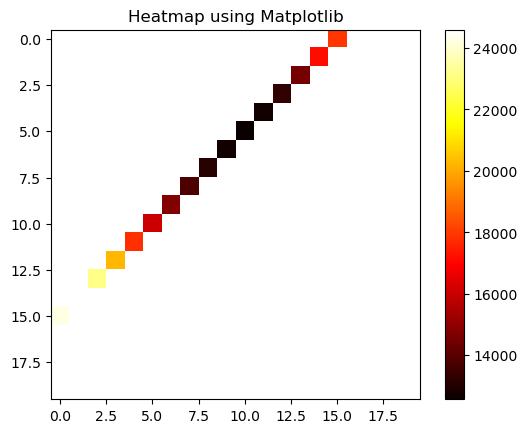

In [185]:
plt.imshow(nlp_array, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add a colorbar
plt.title('Heatmap using Matplotlib')
plt.show()

In [186]:
np.argmin(nlp_array)

0

In [180]:
np.argmin(nlp_array[nlp_array > 0])

5

In [166]:
nlp_array[19, 19]

-525.63720703125

In [24]:
import jax
import jax.numpy as jnp
import jax.random as random

# Create a random key
key = random.PRNGKey(0)

# Generate uniform random numbers
key, subkey = random.split(key)
uniform_array = random.uniform(subkey, shape=(1000, 3)) 


In [192]:
uniform_array[1]

Array([ 6.7934885, 17.82815  , 26.32715  ], dtype=float32)

In [25]:
initial_weight_guess = uniform_array

In [111]:
len(initial_weight_guess)

1000

In [28]:
weight_objective_jacobian = jax.jacfwd(weight_objective)

In [29]:
weight_neg_objective_jacobian = jax.jacfwd(weight_neg_objective)

In [187]:
res = minimize(weight_neg_objective, initial_weight_guess[0], method='BFGS',
                                   options={'disp': True, 'gtol':1e-6}, jac=weight_neg_objective_jacobian)

         Current function value: nan
         Iterations: 2
         Function evaluations: 113
         Gradient evaluations: 113


In [ ]:
res_list = []
for g in tqdm(range(len(initial_weight_guess))):
    print(g)
    res = minimize(weight_neg_objective, initial_weight_guess[g], method='BFGS',
                                   options={'disp': True, 'gtol':1e-6}, jac=weight_neg_objective_jacobian)
    res_list.append(g)

In [56]:
res.x/sum(res.x)

array([0.33825932, 0.40932712, 0.25241356])

In [119]:
from tqdm.notebook import tqdm

In [137]:
solver = jaxopt.ScipyMinimize(fun=weight_neg_objective, method='L-BFGS-B', tol=1e-6,
                                   options={'disp': False, 'gtol':1e-9})
res_list = []
for i, g in enumerate(initial_weight_guess):
    res = solver.run(jnp.array(g))
    res_list.append(res)

In [138]:
posterior_list = [r.state.fun_val for r in res_list]

(array([306., 619.,  64.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-841680.375  , -831477.5625 , -821274.8125 , -811072.     ,
        -800869.1875 , -790666.4375 , -780463.625  , -770260.8125 ,
        -760058.     , -749855.25   , -739652.4375 , -729449.625  ,
        -719246.875  , -709044.0625 , -698841.25   , -688638.5    ,
        -678435.6875 , -668232.875  , -658030.125  , -647827.3125 ,
        -637624.5    , -627421.75   , -617218.9375 , -607016.125  ,
        -596813.3125 , -586610.5625 , -576407.75   , -566204.9375 ,
        -556002.1875 , -545799.375  , -535596.5625 , -525393.8125 ,
        -515191.     , -504988.1875 , -494785.40625, -484582.625  ,
        -474379.8125 , -464177.03125, -453974.

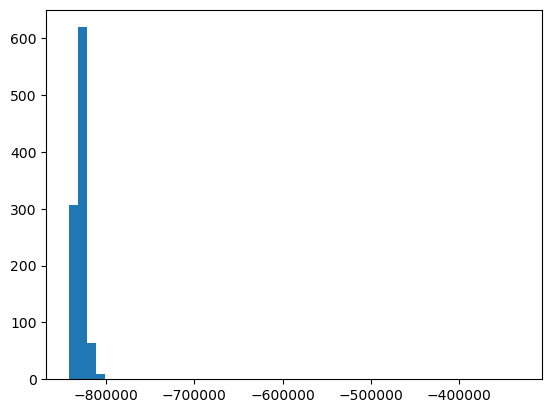

In [145]:
plt.hist(posterior_list, 50)

In [27]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_simplex

In [204]:
pg = ProjectedGradient(fun=weight_neg_objective, projection=projection_simplex, implicit_diff=True)
pg_sol = pg.run(initial_weight_guess[1], hyperparams_proj=30)

In [205]:
pg_sol

OptStep(params=Array([ 5.0000157,  9.999986 , 14.999993 ], dtype=float32), state=ProxGradState(iter_num=Array(336, dtype=int32, weak_type=True), stepsize=Array(0.015625, dtype=float32), error=Array(0.0004767, dtype=float32), aux=None, velocity=Array([ 5.000012,  9.99998 , 14.999996], dtype=float32), t=Array(170.28049, dtype=float32, weak_type=True)))

In [207]:
pg_sol.params

Array([ 5.0000157,  9.999986 , 14.999993 ], dtype=float32)

In [33]:
pg_list = []
pg = ProjectedGradient(fun=weight_neg_objective, projection=projection_simplex, implicit_diff=True)
for i, g in enumerate(initial_weight_guess[:100]):
    print(i)
    pg_sol = pg.run(g, hyperparams_proj=30)
    pg_list.append(pg_sol)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [35]:
sol_list = [x.params for x in pg_list]

In [36]:
sol_list

[Array([ 5.000056,  9.999955, 14.999989], dtype=float32),
 Array([nan, nan, nan], dtype=float32),
 Array([ 4.999948, 10.000032, 15.000021], dtype=float32),
 Array([nan, nan, nan], dtype=float32),
 Array([ 4.999985, 10.000006, 15.000014], dtype=float32),
 Array([ 4.999991, 10.00001 , 14.999999], dtype=float32),
 Array([ 5.0000033, 10.000004 , 14.999992 ], dtype=float32),
 Array([ 4.999985 , 10.000002 , 15.0000105], dtype=float32),
 Array([ 4.9999943, 10.000008 , 14.999999 ], dtype=float32),
 Array([ 4.999978 , 10.000011 , 15.0000105], dtype=float32),
 Array([ 5.0000076,  9.999983 , 15.0000105], dtype=float32),
 Array([ 4.99991 , 10.000052, 15.000037], dtype=float32),
 Array([ 4.999942, 10.000034, 15.000029], dtype=float32),
 Array([ 4.9999113, 10.000052 , 15.000036 ], dtype=float32),
 Array([ 4.999997 ,  9.9999895, 15.000014 ], dtype=float32),
 Array([ 4.999999, 10.000002, 15.000004], dtype=float32),
 Array([ 5.0000963,  9.999937 , 14.999968 ], dtype=float32),
 Array([ 4.999987 , 10.000

In [149]:
np.argmin(posterior_list)

951

In [150]:
res_list[951].params

Array([1.5287363e+13, 3.7541932e+13, 2.3137312e+13], dtype=float32)

In [151]:
res.params

Array([1.1141534e+13, 1.0760614e+13, 1.5732408e+13], dtype=float32)

In [148]:
res_list[951].params/sum(res_list[951].params)*30

Array([ 8.502366,  9.648247, 11.849389], dtype=float32)

In [99]:
def callback(xk):
    convergence_path.append(np.copy(xk))
    fun_val.append(weight_neg_objective(xk))

In [115]:
# Create a list to store the path of the optimizer
convergence_path = []
fun_val = []

solver = jaxopt.ScipyMinimize(fun=weight_neg_objective, method='L-BFGS-B', tol=1e-6,
                                   options={'disp': True, 'gtol':1e-9}, callback=callback)
res = solver.run(jnp.array(initial_weight_guess[8]))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13550D+04    |proj g|=  3.31283D+01

At iterate    1    f=  5.13323D+04    |proj g|=  1.12128D+01


 This problem is unconstrained.



At iterate    2    f=  5.13215D+04    |proj g|=  8.12786D+00

At iterate    3    f=  5.13057D+04    |proj g|=  4.77459D+00

At iterate    4    f=  5.12918D+04    |proj g|=  3.00632D+00

At iterate    5    f=  5.12771D+04    |proj g|=  1.84494D+00

At iterate    6    f=  5.12628D+04    |proj g|=  1.14329D+00

At iterate    7    f=  5.12483D+04    |proj g|=  7.05872D-01

At iterate    8    f=  5.12339D+04    |proj g|=  4.36421D-01

At iterate    9    f=  5.12194D+04    |proj g|=  2.69684D-01

At iterate   10    f=  5.12050D+04    |proj g|=  1.66683D-01

At iterate   11    f=  5.11906D+04    |proj g|=  1.03014D-01

At iterate   12    f=  5.11761D+04    |proj g|=  6.36664D-02

At iterate   13    f=  5.11617D+04    |proj g|=  3.93479D-02

At iterate   14    f=  5.11473D+04    |proj g|=  2.43184D-02

At iterate   15    f=  5.11328D+04    |proj g|=  1.50296D-02

At iterate   16    f=  5.11184D+04    |proj g|=  9.28878D-03

At iterate   17    f=  5.11040D+04    |proj g|=  5.74078D-03

At iter

In [116]:
res.params / np.sum(res.params)

Array([0.25844583, 0.3424107 , 0.39914346], dtype=float32)

In [105]:
# Convert the convergence path to a NumPy array for easier manipulation
convergence_path = np.array(convergence_path)

In [106]:
convergence_path

array([[7.76643799e+03, 5.28974365e+03, 4.70479443e+03],
       [9.15153906e+03, 8.78097656e+03, 8.54989941e+03],
       [1.23754004e+04, 1.40285488e+04, 1.35855029e+04],
       [1.95279531e+04, 2.30321797e+04, 2.24270566e+04],
       [3.13331992e+04, 3.71211602e+04, 3.61677031e+04],
       [5.07618047e+04, 6.01650859e+04, 5.86248867e+04],
       [8.20788750e+04, 9.72878125e+04, 9.47977656e+04],
       [1.32838141e+05, 1.57453234e+05, 1.53423406e+05],
       [2.14916609e+05, 2.54741062e+05, 2.48221328e+05],
       [3.47754656e+05, 4.12194219e+05, 4.01644656e+05],
       [5.62671312e+05, 6.66935438e+05, 6.49866125e+05],
       [9.10425938e+05, 1.07912975e+06, 1.05151050e+06],
       [1.47309712e+06, 1.74606488e+06, 1.70137712e+06],
       [2.38352325e+06, 2.82519500e+06, 2.75288725e+06],
       [3.85662025e+06, 4.57125950e+06, 4.45426400e+06],
       [6.24014350e+06, 7.39645350e+06, 7.20715200e+06],
       [1.00967640e+07, 1.19677140e+07, 1.16614150e+07],
       [1.63369080e+07, 1.93641

In [51]:
convergence_path = convergence_path / np.sum(convergence_path, axis=1)[:, np.newaxis]

AxisError: axis 1 is out of bounds for array of dimension 1

Text(0.5, nan, 'Weight 3')

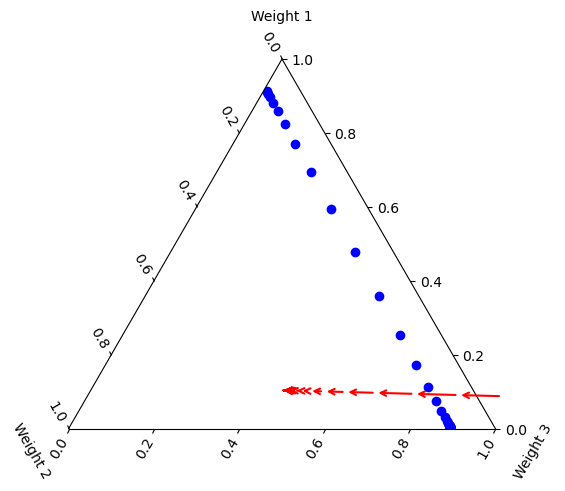

In [44]:
# Plotting
import mpltern
fig, ax = plt.subplots(subplot_kw={'projection': 'ternary'})

ax.scatter(convergence_path[:, 0], convergence_path[:, 1], convergence_path[:, 2], marker='o', color='blue')

# Draw arrows between points
for i in range(len(convergence_path)
               - 1):
    start = convergence_path[i]
    end = convergence_path[i + 1]
    ax.annotate('', xy=end[:2], xytext=start[:2],
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
    
ax.set_tlabel('Weight 1')
ax.set_llabel('Weight 2')
ax.set_rlabel('Weight 3')